# Implementing Softmax for the Uninitiated 

The softmax classification function (aka multiclass logistic regression or maxent classifier in traditional machine learning) is a essential building block in deep learning networks.

However, many papers and even textbooks are relativly brief on the details of implementing the learning updates for the softmax function. In this notebook, we will show a detailed, amost painful, step-by-step derivation of the update rule for a simple one-layer softmax network with mini-batch stochastic gradient descent.

## The Softmax Function

The [softmax function](http://en.wikipedia.org/wiki/Softmax_function) is the generalization of the [logistic function](http://en.wikipedia.org/wiki/Logistic_function) to multiple categories. The softmax function takes an $c$-dimensional input vector $\mathbf{z}$ and outputs a $c$-dimensional vector of non-negative, real values and can be interpreted as a multi-class categorical probability distribution. 

The softmax function is a normalized exponential and is defined as:

$$
y_k = \sigma_k(\mathbf{z}) = \frac{e^{z_k}}{\sum_{i=1}^{N} e^{z_i}}
$$

The denominator $Z = \sum_{i=1}^{N} e^{z_k}$ acts as a normalizer that ensures that the values sum to unity $ \sum_{k=1}^{N} y_k = 1$. We can interpret $y_k$ as the probability of class $k$ given the input $\mathbf{z}$:

$$
P(y = k | \mathbf{z}) = \sigma_k(\mathbf{z}) = \frac{e^{z_k}}{Z}
$$.

Let's go ahead and define the softmax function in Python. Note that for computational efficience we compute the softmax over a complete ''minibatch'' of size ``n_batch`` instead of a single input and we substract the maximum value in $\mathbf{z}$ for [numerical stability](https://lingpipe-blog.com/2009/03/17/softmax-without-overflow/).|

In [17]:
# python imports
import numpy as np

In [19]:
# define softmax

def softmax(self, Z):
    """Compute softmax activations      
    Z is a matrix with dimension (n_batch, n_classes)                                                            
    """
    ex = np.exp(Z-np.max(Z, axis=1, keepdims=True))
    return ex / ex.sum(axis=1, keepdims=True)

## Derivative of the Softmax Function

To train a neural network, we need to be able to compute the gradient updates of each layer with respect to its inputs. So let's start by computing the partial derivative of the softmax function with respect to a single input $z_i$ using the quotient rule. We distinguish two cases.

\begin{eqnarray}
\text{if}\ k = i &:&\frac{\partial y_i}{\partial z_i} = \frac{\partial \frac{e^{z_i}}{Z}} {\partial z_i} = \frac{e^{z_i} Z - e^{z_i} e^{z_i}} {Z^2} = \frac{e^{z_i}} {Z} \frac{Z - e^{z_i}} {Z} = \frac{e^{z_i}} {Z} (1 - \frac{e^{z_i}} {Z}) = y_i (1-y_i) \\
\text{if}\ k \neq i &:& \frac{\partial y_k}{\partial z_i} = \frac{\partial \frac{e^{z_k}}{Z}} {\partial z_i} = \frac{0 - e^{z_k} e^{z_i}} {Z^2} = - \frac{e^{z_k}} {Z} \frac{e^{z_i}} {Z} = - y_k y_i
\end{eqnarray}


## Cross-entropy cost function 
When we use the softmax function as the output layer in a neural network  classifier, we want to minimize the difference between the predicted output and the true labels $\mathbf{t}$. 
The loss function to minimize is the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy).

$$
\mathcal{L}(\mathbf{t}, \mathbf{y}) = -\sum_{i=1}^{N} t_i \log{y_i}
$$

For multiclass classification, there will be exactly one $t_i = 1$ and the cross entropy loss is equivalent to the log loss, the negative log-likelihood of the correct class under the model. The cross entropy loss over a minibatch of $M$ examples is:

$$
\mathcal{L}(T, Y) = \mathcal{L}(\mathbf{t_j}, \mathbf{y_j}) =  \sum_{j=1}^{M}\sum_{i=1}^{N} t_{ji} \log{y_{ji}}
$$


## Derivative of the cross-entropy cost function  
Now let's compute the derivative for the cross-entropy loss with respoect to its inputs. Using the chain rule and the derivative for the softmax function from above, we get:

\begin{eqnarray}
\frac{\partial \mathcal{L}(\mathbf{t}, \mathbf{y})}{\partial z_i} &=& - \sum_{j=1}^{N} \frac{\partial t_j \log y_j}{\partial z_i} = -\sum_{j=1}^{N} t_j \frac{\partial \log y_j}{\partial z_i} 
= - \sum_{j=1}^{N} t_j \frac{1}{y_j} \frac{\partial y_j}{\partial z_i} = - \frac{t_i}{y_i} \frac{\partial y_i}{z_i} - \sum_{j\neq i} \frac{t_j}{y_j} \frac{\partial y_j}{\partial z_i} \\
&=& - \frac{t_i}{y_i} y_i(1-y_i) -\sum_{j\neq i} \frac{t_j}{y_i} (-y_j y_i) = -t_i + t_i y_i + \sum_{j\neq i} \frac{t_j}{y_i} =  -t_i  + \sum_{j=1}^{N} t_j y_i = -t_i  + y_i \sum_{j=1}^{N} t_j \\
&=& y_i - t_i 
\end{eqnarray}

The result is surprisingly simple, the derivative of the cross entropy loss with respects to its inputs is just the differenc between the output activation and the true class. 


## Weight update rule 
So far, we have started from the inputs to the softmax layer $\mathbf{z}$. These inputs in turn, are the result of the previous layer's outputs (or raw features input) $\mathbf{x}$ multiplied by a weight matrix $W$.

$$
\mathbf{z} = W (\mathbf{t}, \mathbf{y}) = -\sum_{i=1}^{N} t_i \log{y_i}
$$


### Acknowledgement 
This  excellent [blog post on Peter's notes blog](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/) was a great help for the derivation of the math and for how to present the subject in an accessbile and clear way. 

### Generate a data set

In [8]:
%matplotlib inline  

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import matplotlib.pyplot as plt

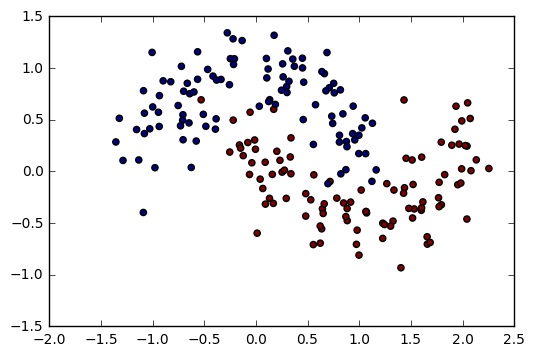

In [9]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.2)
plt.scatter(X[:,0], X[:, 1], c=y)

In [14]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [15]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [13]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

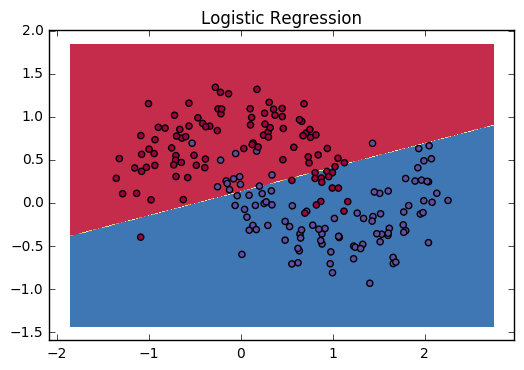

In [16]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

$$
\sum_{i} y_{i} \hat{y}
$$